# Homework 3 - Explaining wine quality prediction with LIME

The goal of this notebook is to explain the predictions of models on the wine quality dataset.
We use the same models that we trained in Homework 1, namely RandomForestClassifier and LogisticRegression.

To depict the sample data, we present two representative data points:
| Feature               | 1     | 115   |
|-----------------------|-------|-------|
| fixed acidity         | 6.3   | 5.5   |
| volatile acidity      | 0.300 | 0.485 |
| citric acid           | 0.34  | 0.00  |
| residual sugar        | 1.6   | 1.5   |
| chlorides             | 0.049 | 0.065 |
| free sulfur dioxide   | 14.0  | 8.0   |
| total sulfur dioxide  | 132.0 | 103.0 |
| density               | 0.994 | 0.994 |
| pH                    | 3.30  | 3.63  |
| sulphates             | 0.49  | 0.40  |
| alcohol               | 9.5   | 9.7   |

For which the RandomForest model estimates the likelihood of being a quality wine as 0.01 and 0.91 respectively.

### Stability of explanations

LIME explanations depend on random seed and we may be concerned about variability in the resulting explanations. In this section, we investigate the stability of LIME explanations.

We choose an observation with id 1 and show explanations of RandomForectClassifier prediction for three different seeds:

<div>
<img src="hw3_files/stability.png" width="600"/>
</div>

We can see that explanations vary slightly - the three most important variables - `free sulfur dioxide`, `total sulfur dioxide` and  `residual sugar` - retain their importance ranks across all seeds. There are however some small differences, for instance, the fourth most important variable sometimes swapped from `pH` to `citric acid`. 

For this example LIME explanations are fairly stable and differ slightly with the random seed.

#### Explanations of different models

In this section, we aim to contrast the explanations provided by the previous model with those of Logistic Regression. This examination is particularly insightful because the predictions of Logistic Regression are based on the linearity of variables and their log-odds. In contrast, the Random Forest can capture far more intricate interactions between variables.

<div>
<img src="hw3_files/different_models1.png" width="600"/>
</div>
<div>
<img src="hw3_files/different_models2.png" width="600"/>
</div>

In my assessment, the features considered as highly significant largely align with those from the RandomForest model. Less significant features differ in a more unpredictable pattern, showing that 

However, there is one interesting systematic difference - the logistic regression model consistently shows *higher importance for the percentage of alcohol*. This could be attributed to the inherent nature of logistic regression, which assumes a linear relationship between the predictors and the log-odds. The alcohol variable might exhibit a more linear pattern, making it more influential in the logistic regression model. On the other hand, RandomForest, being a tree-based model, can capture non-linear relationships and complex interactions, potentially distributing importance across a broader set of features. 

## Appendix

#### 0. Import packages

In [5]:
!pip install lime

In [78]:
import dalex as dx
import lime

import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5,3)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

### 1. Load dataset

In [21]:
TARGET_COL = 'is_good'

cols = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    TARGET_COL
]

df = pd.read_csv('wine_quality.csv', header=0, names=cols)
df[TARGET_COL] = df[TARGET_COL].replace(-1, 0)
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (4898, 11)
y: (4898,)


#### 2. Fit models from Homework 1

In [22]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "Forest": RandomForestClassifier()
}

for model in models.values():
    model.fit(X, y)

#### 3. EXPLAIN

In [23]:
explainers = {}
for model_name, model in models.items():
    explainer = dx.Explainer(model, X, y)
    explainers[model_name] = explainer

Preparation of a new explainer is initiated

  -> data              : 4898 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4898 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x133f37700> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.98e-05, mean = 0.0374, max = 0.789
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.6, mean = -6.09e-06, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 4898 rows 11 cols
  -> target variable   :

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### 3.1 Calculate the predictions for some selected observations

In [87]:
indexes = [1, 115, 324]
X_sample = X.iloc[indexes]
print(X_sample.head())

     fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1              6.3             0.300         0.34             1.6      0.049   
115            5.5             0.485         0.00             1.5      0.065   
324            8.3             0.410         0.51             2.0      0.046   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1                   14.0                 132.0    0.994  3.30       0.49   
115                  8.0                 103.0    0.994  3.63       0.40   
324                 11.0                 207.0    0.993  3.02       0.55   

     alcohol  
1        9.5  
115      9.7  
324     11.4  


In [95]:
explainers["Forest"].predict(X_sample)

array([0.01, 0.91, 0.1 ])

##### 3.2 Calculate the decomposition of these predictions with LIME
3.3 Compare LIME for various observations in the dataset. Use different seeds to see stability.

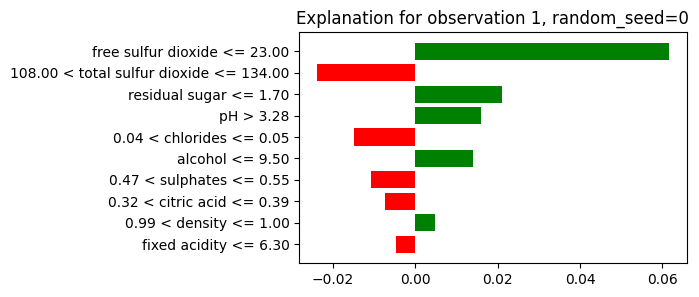

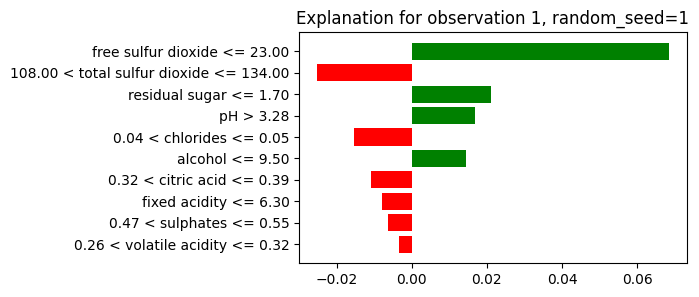

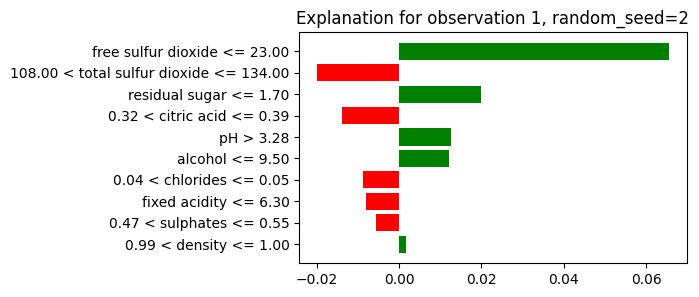

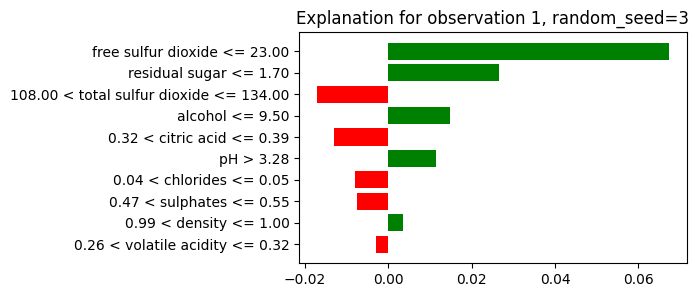

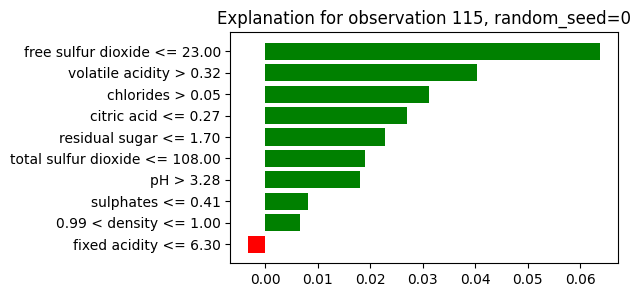

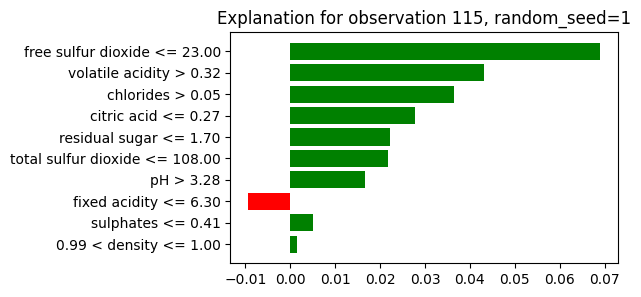

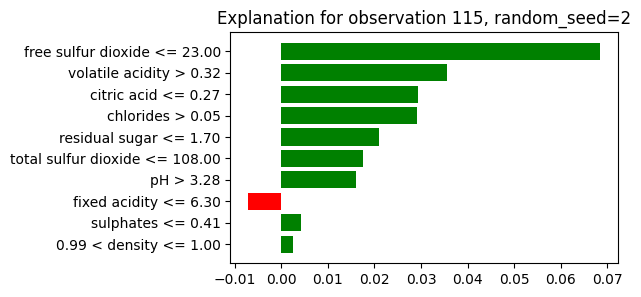

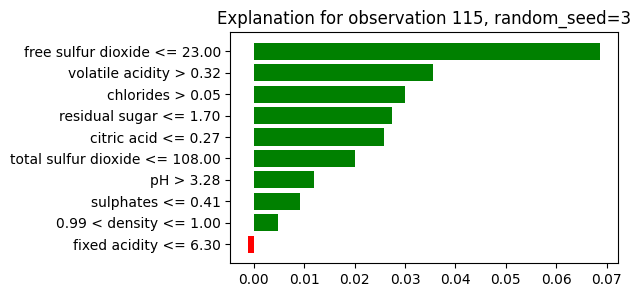

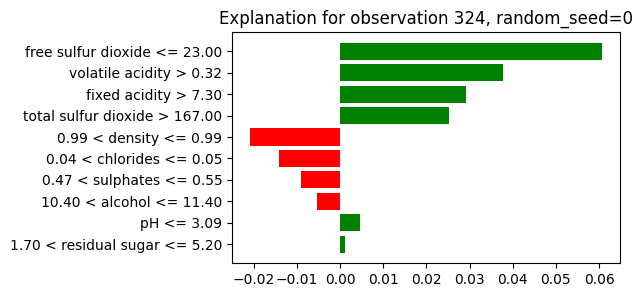

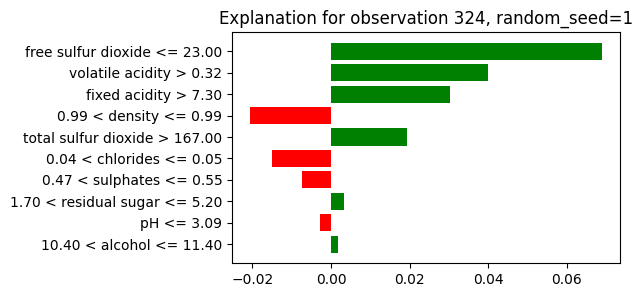

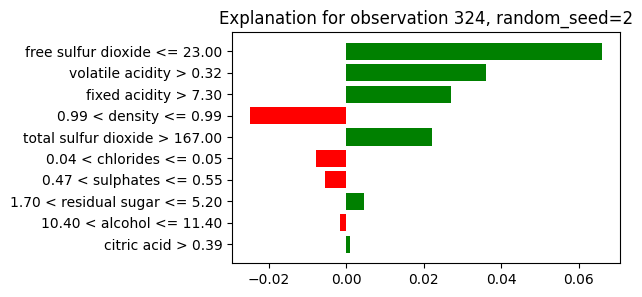

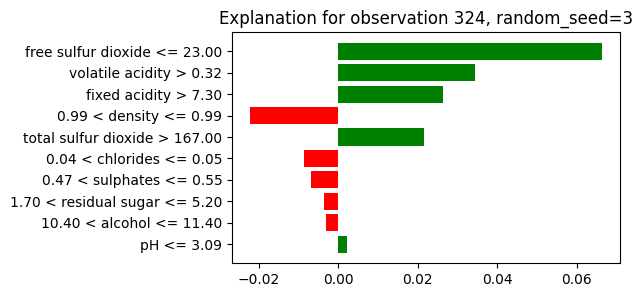

In [91]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

num_seeds = 4
for obs_id, obs in zip(indexes, X_sample.values):
    for seed in range(num_seeds):
        set_seed(seed)
        explanation = explainers["Forest"].predict_surrogate(obs)
        explanation.plot(return_figure=True)
        plt.title(f'Explanation for observation {obs_id}, random_seed={seed}')     

##### 3.4 Compare LIME between at least two different models. Are there any systematic differences across many observations?

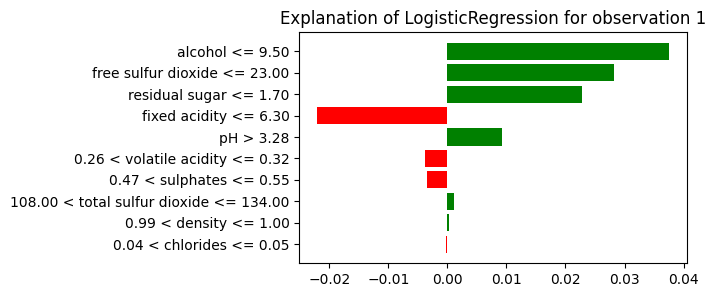

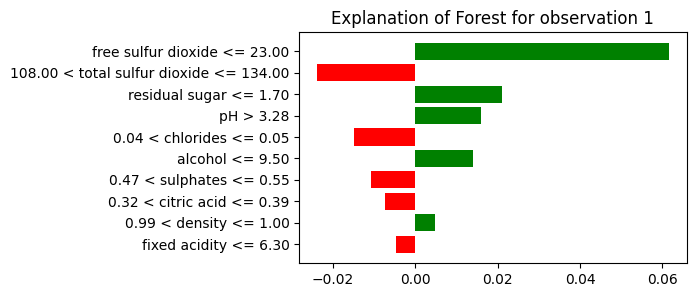

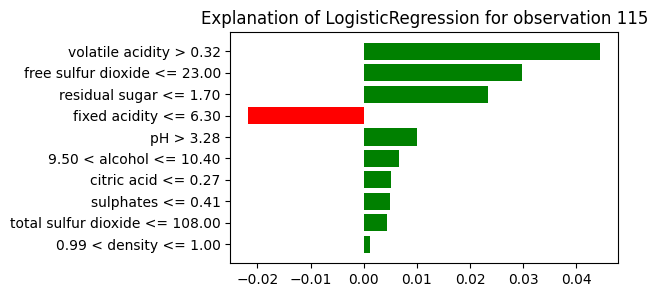

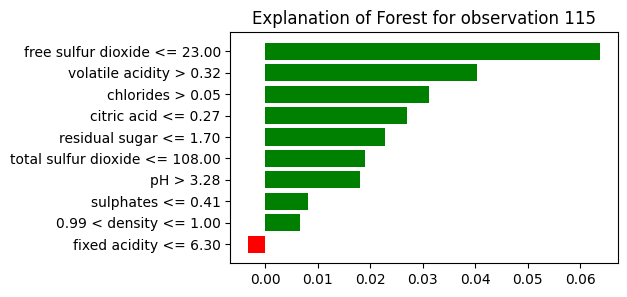

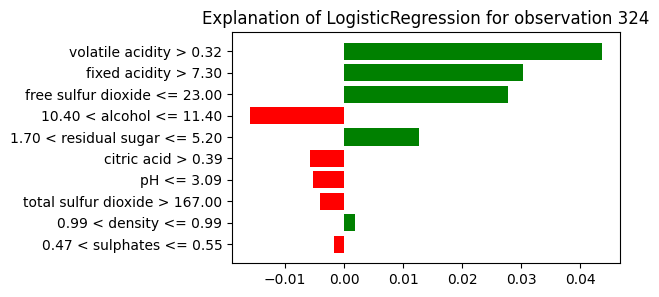

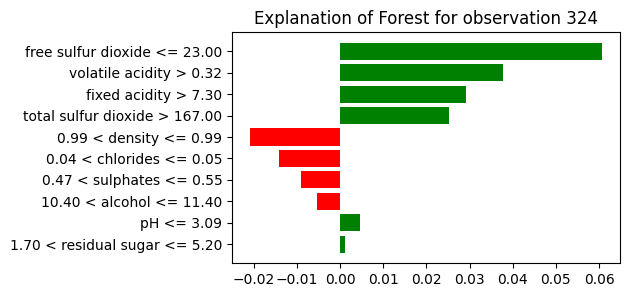

In [90]:
for obs_id, obs in zip(indexes, X_sample.values):
    for model_name, explainer in explainers.items():
        set_seed(0)
        explanation = explainer.predict_surrogate(obs)
        explanation.plot(return_figure=True)
        plt.title(f'Explanation of {model_name} for observation {obs_id}')